# Example-13: Line tracking (CPU)

In [1]:
# In this example a simple line tracking setup is illustrated
# There is not special factory for creating sequencies of elements
# Lines should be explicitly defined
# Alignment and fringe effects should be explicitly added

In [2]:
import jax
from jax import jit
from jax import vmap
from jax import pmap
from jax import jacrev

from elementary import nest
from elementary import nest_list

from elementary.drift import drift_factory
from elementary.quadrupole import quadrupole_factory
from elementary.sextupole import sextupole_factory
from elementary.dipole import dipole_factory

from matplotlib import pyplot as plt

jax.numpy.set_printoptions(linewidth=256, precision=12)

In [3]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [4]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [5]:
# Single CPU can be treated as several physical devices 
# Number of physical devices can be set with
# export JAX_PLATFORMS=cpu
# export XLA_FLAGS="--xla_force_host_platform_device_count=x"

count = jax.local_device_count()
print(count)

12


In [6]:
# Define generic elements
# Note, number of iterations is setup in advance
# Thus, if you have elements of different lenght, you might want to create an element for each group
# For the purpose of testing, exact solutions for drift and dipole are not used
# Step length is chosen to be 1 cm for all elements
# There is no need to jit compile elements at this stage, use jit for the final line

drif = drift_factory(exact=False, order=1, iterations=25)
quad = quadrupole_factory(order=1, iterations=50)
sext = sextupole_factory(order=1, iterations=25)
bend = dipole_factory(exact=False, order=1, iterations=350)

In [7]:
# Set element parameters

ldr = jax.numpy.float64(0.25)
lqf = jax.numpy.float64(0.50)
lqd = jax.numpy.float64(0.50)
lsf = jax.numpy.float64(0.25)
lsd = jax.numpy.float64(0.25)
lbm = jax.numpy.float64(3.50)

kqf = jax.numpy.float64(+0.1948)
kqd = jax.numpy.float64(-0.1881)

ksf = jax.numpy.float64(+0.7870)
ksd = jax.numpy.float64(-1.2254)

angle = jax.numpy.float64(jax.numpy.pi/4.0)

In [8]:
# Set zero initial condition

(q_x, q_y, q_s) = qs = jax.numpy.array([0.0, 0.0, 0.0])
(p_x, p_y, p_s) = ps = jax.numpy.array([0.0, 0.0, 0.0])
qsps = jax.numpy.hstack([qs, ps])

In [9]:
# Set and test cell
# Here a subset of lattice parametes is fixed 
# Add the parameter to signature to make the final result differentiable with respect to it
# You can also group parametes

def cell(qsps, kq, ks):
    kqf, kqd = kq
    ksf, ksd = ks
    qsps = quad(qsps, lqf, kqf, 0.0)
    qsps = drif(qsps, ldr)
    qsps = sext(qsps, lsf, ksf, 0.0)
    qsps = drif(qsps, ldr)
    qsps = bend(qsps, lbm, angle)
    qsps = drif(qsps, ldr)
    qsps = sext(qsps, lsf, ksd, 0.0)
    qsps = drif(qsps, ldr)
    qsps = quad(qsps, lqd, kqd, 0.0)
    qsps = quad(qsps, lqd, kqd, 0.0)
    qsps = drif(qsps, ldr)
    qsps = sext(qsps, lsf, ksd, 0.0)
    qsps = drif(qsps, ldr)
    qsps = bend(qsps, lbm, angle)
    qsps = drif(qsps, ldr)
    qsps = sext(qsps, lsf, ksf, 0.0)
    qsps = drif(qsps, ldr)
    qsps = quad(qsps, lqf, kqf, 0.0)
    return qsps

kq = jax.numpy.stack([kqf, kqd])
ks = jax.numpy.stack([ksf, ksd])

print(cell(qsps, kq, ks))

[0. 0. 0. 0. 0. 0.]


In [10]:
# Set ring

ring = nest(2**2, cell)
print(ring(qsps, kq, ks))

[0. 0. 0. 0. 0. 0.]


In [11]:
%%timeit
ring(qsps, kq, ks).block_until_ready()

1.28 s ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
# Set ring (compiled)

ring = jit(nest(2**2, cell))
print(ring(qsps, kq, ks))

[0. 0. 0. 0. 0. 0.]


In [13]:
%%timeit
ring(qsps, kq, ks).block_until_ready()

2.5 ms ± 2.81 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
# Set tracking

task = nest(2**10, ring)
print(task(qsps, kq, ks))

[0. 0. 0. 0. 0. 0.]


In [15]:
%%timeit

task(qsps, kq, ks).block_until_ready()

3.8 s ± 44.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# Set tracking (compiled)

task = jit(nest(2**10, ring))
print(task(qsps, kq, ks))

[0. 0. 0. 0. 0. 0.]


In [17]:
%%timeit
task(qsps, kq, ks).block_until_ready()

2.42 s ± 5.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
# Set initial conditions

size = 2**3
grid = jax.numpy.array(size*count*[qsps])
grid = grid.at[:, 0].set(jax.numpy.linspace(0.00, 0.25, size*count))
print(grid.shape)

(96, 6)


In [19]:
# Set tracking (compiled & full trajectory)

task = jit(nest_list(2**10, ring))
print(task(qsps, kq, ks).shape)

(1024, 6)


In [20]:
%%time

# Track

qx, _, _, px, _, _ = jax.numpy.stack([task(qsps, kq, ks) for qsps in grid]).T.block_until_ready()
print(qx.shape)
print(px.shape)

(1024, 96)
(1024, 96)
CPU times: user 4min 5s, sys: 6.55 ms, total: 4min 5s
Wall time: 4min 4s


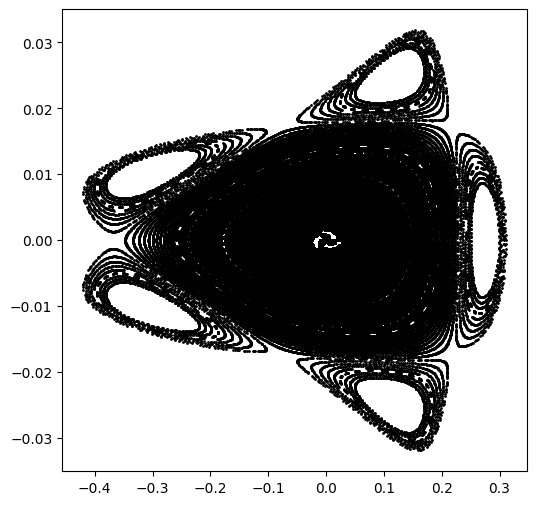

In [21]:
# Plot

plt.figure(figsize=(6, 6))
plt.scatter(qx, px, s=1, color='black')
plt.show()

In [22]:
%%time

# Vectorized mapping 
# Note, vmap will trigger recompilaton of its callable
# The real appeal of using jitted vmap comes from applying ones compiled function to a different 'batch'

fn = jit(vmap(task, in_axes=(0, None, None)))
qx, _, _, px, _, _ = fn(grid, kq, ks).T.block_until_ready()

CPU times: user 58.7 s, sys: 139 ms, total: 58.9 s
Wall time: 56.1 s


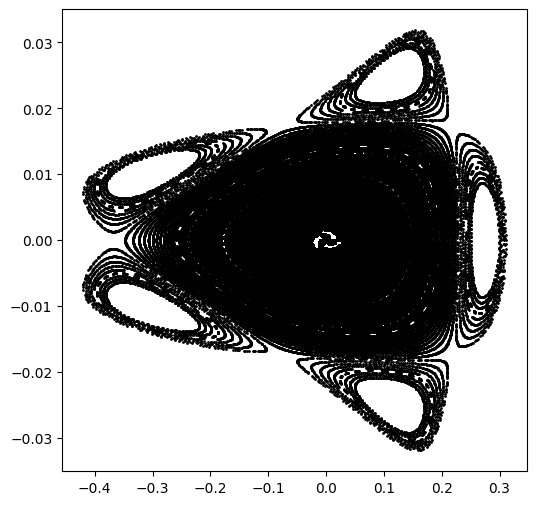

In [23]:
# Plot

plt.figure(figsize=(6, 6))
plt.scatter(qx, px, s=1, color='black')
plt.show()

In [24]:
%%time

# Second invocation

qx, _, _, px, _, _ = fn(grid, kq, ks).T.block_until_ready()

CPU times: user 54.5 s, sys: 38.9 ms, total: 54.5 s
Wall time: 54.3 s


In [25]:
%%time

# Combining device map with vectorized map

fn = pmap(jit(vmap(task, in_axes=(0, None, None))), in_axes=(0, None, None))
qx, _, _, px, _, _ = fn(grid.reshape(count, size, -1), kq, ks).reshape(size*count, 2**10, -1).T.block_until_ready()
print(qx.shape)
print(px.shape)

(1024, 96)
(1024, 96)
CPU times: user 3min 4s, sys: 544 ms, total: 3min 5s
Wall time: 20.8 s


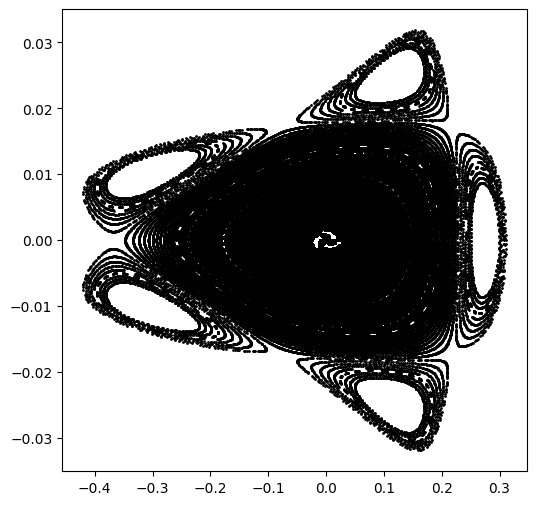

In [26]:
# Plot

plt.figure(figsize=(6, 6))
plt.scatter(qx, px, s=1, color='black')
plt.show()

In [27]:
%%time

# Second invocation

qx, _, _, px, _, _ = fn(grid.reshape(count, size, -1), kq, ks).reshape(size*count, 2**10, -1).T.block_until_ready()
print(qx.shape)
print(px.shape)

(1024, 96)
(1024, 96)
CPU times: user 2min 43s, sys: 414 ms, total: 2min 43s
Wall time: 17.2 s
